In [5]:
import os
import sys 

PROJECT_ROOT_DIR = "latent-communication"

current_dir = os.getcwd()

# Find the project root by walking up the directory tree
while current_dir:
    if os.path.basename(current_dir) == PROJECT_ROOT_DIR:
        break  # Found the project root!
    current_dir = os.path.dirname(current_dir)
else:
    raise FileNotFoundError(f"Project root '{PROJECT_ROOT_DIR}' not found in the directory tree.")

os.chdir(current_dir)
# Add the project root and any necessary subdirectories to sys.path
sys.path.insert(0, current_dir) 
sys.path.insert(0, os.path.join(current_dir, "utils"))  # Add the utils directory if needed

print(os.getcwd())

from pathlib import Path
import torch.nn as nn

import itertools
import torch
import numpy as np
from tqdm import tqdm
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import logging


from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

from utils.dataloaders.full_dataloaders import DataLoaderMNIST, DataLoaderFashionMNIST, DataLoaderCIFAR10, DataLoaderCIFAR100
from utils.visualization import (
    visualize_mapping_error,
    visualize_latent_space,
    plot_latent_space,
    highlight_cluster,
)

from utils.get_mapping import load_mapping
from utils.model import load_model, get_transformations


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Config:
    def __init__(self, **entries):
        self.__dict__.update(entries)
def define_dataloader(file, file2, use_test_set=False):
    if file.strip("_")[0] != file2.strip("_")[0]:
        logging.error("The datasets are different")
    # Define the dataloaders
    name_dataset, name_model, size_of_the_latent, seed = file.strip(".pth").split("_")
    augumentation = get_transformations(name_model)
    if name_dataset.lower() == "mnist":
        dataloader = DataLoaderMNIST(transformation=augumentation, batch_size=64, seed=int(seed))
    if name_dataset.lower() == "fmnist":
        dataloader = DataLoaderFashionMNIST(transformation=augumentation,batch_size=64, seed=int(seed))
    if name_dataset.lower() == "cifar10":
        dataloader = DataLoaderCIFAR10(transformation=augumentation,batch_size=64, seed=int(seed))
    if name_dataset.lower() == "cifar100":
        dataloader = DataLoaderCIFAR100(transformation=augumentation,batch_size=64, seed=int(seed))
    if use_test_set:
        full_dataset_images, full_dataset_labels = dataloader.get_full_test_dataset()
    else:
        full_dataset_images, full_dataset_labels = dataloader.get_full_train_dataset()
    return full_dataset_images, full_dataset_labels, len(np.unique(full_dataset_labels.numpy()))

/Users/mariotuci/Documents/latent-communication


  0%|          | 0/6 [00:00<?, ?it/s]/var/folders/yh/rbd67mcj2zd4nychzgcydvt40000gn/T/ipykernel_96525/1944307494.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decoded_transformed = model2.decode(torch.tensor(transformed_latent_space, dtype=torch.float32).to(images.device)).detach().cpu().numpy()


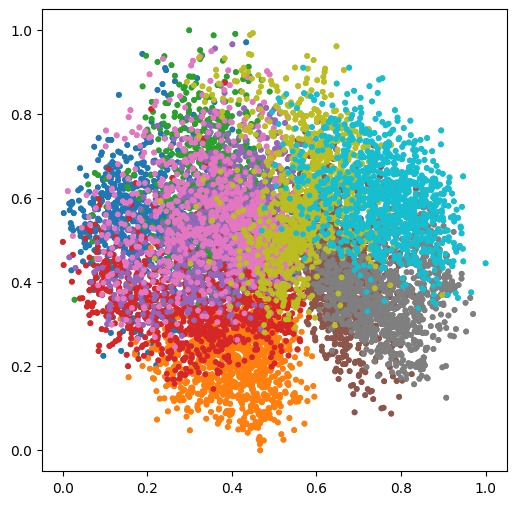

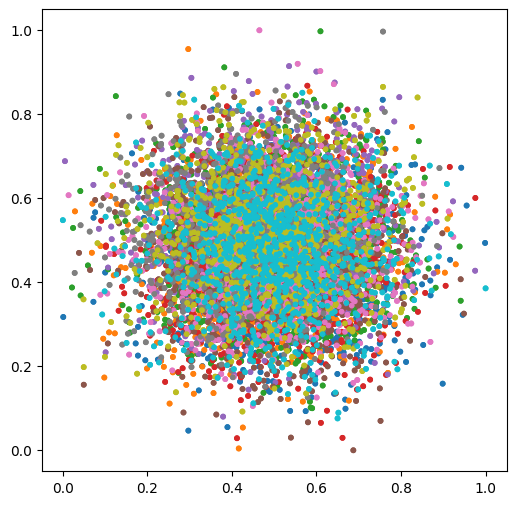

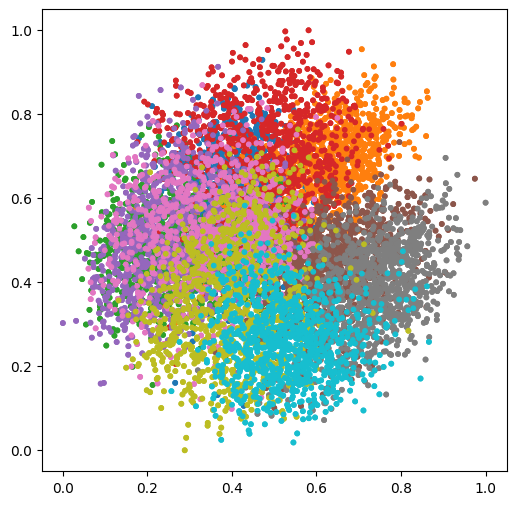

 17%|█▋        | 1/6 [00:02<00:14,  2.98s/it]/var/folders/yh/rbd67mcj2zd4nychzgcydvt40000gn/T/ipykernel_96525/1944307494.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decoded_transformed = model2.decode(torch.tensor(transformed_latent_space, dtype=torch.float32).to(images.device)).detach().cpu().numpy()


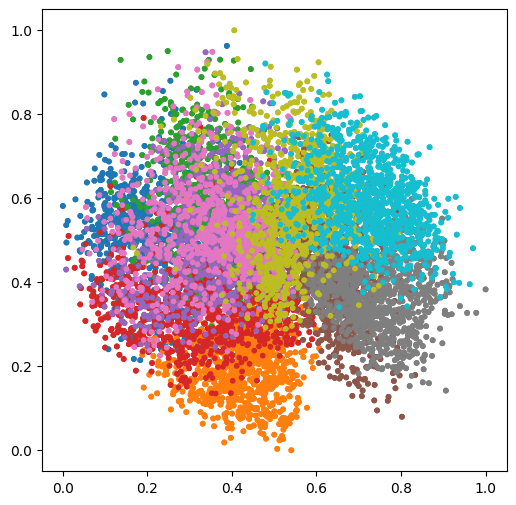

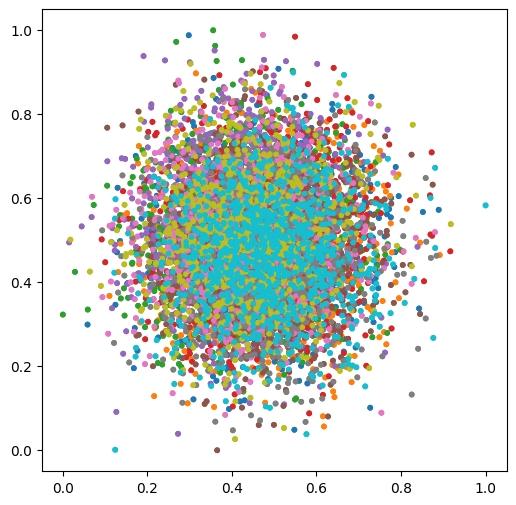

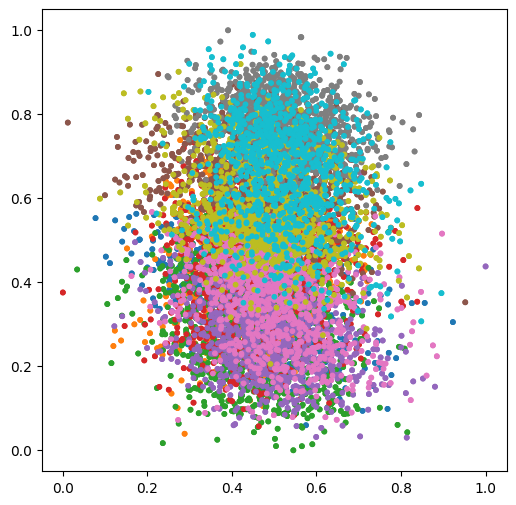

 33%|███▎      | 2/6 [00:05<00:09,  2.47s/it]/var/folders/yh/rbd67mcj2zd4nychzgcydvt40000gn/T/ipykernel_96525/1944307494.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decoded_transformed = model2.decode(torch.tensor(transformed_latent_space, dtype=torch.float32).to(images.device)).detach().cpu().numpy()


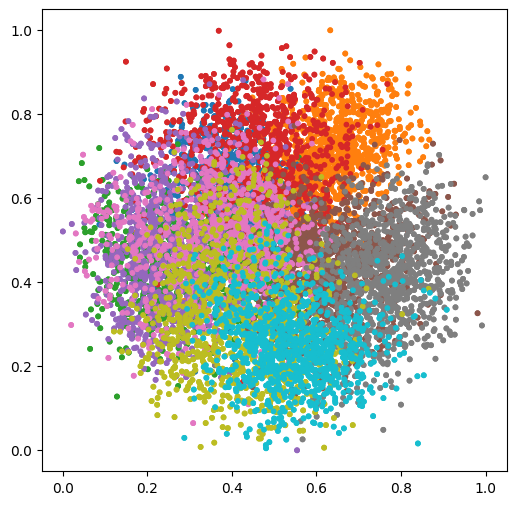

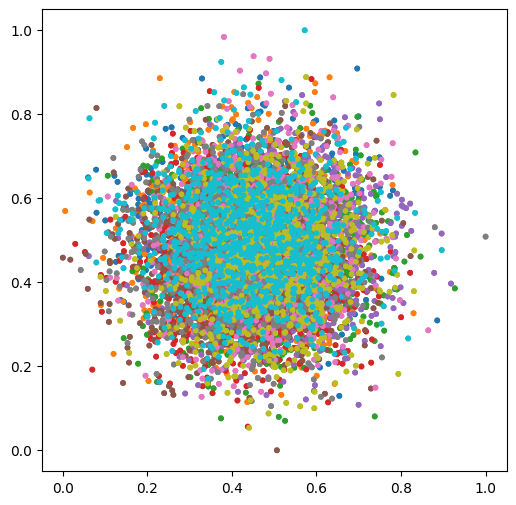

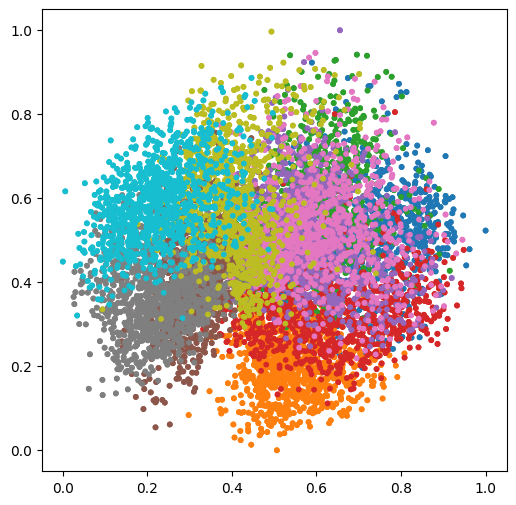

 50%|█████     | 3/6 [00:07<00:06,  2.31s/it]/var/folders/yh/rbd67mcj2zd4nychzgcydvt40000gn/T/ipykernel_96525/1944307494.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decoded_transformed = model2.decode(torch.tensor(transformed_latent_space, dtype=torch.float32).to(images.device)).detach().cpu().numpy()


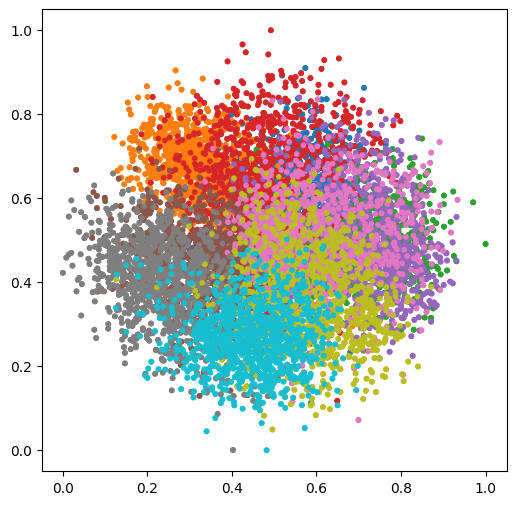

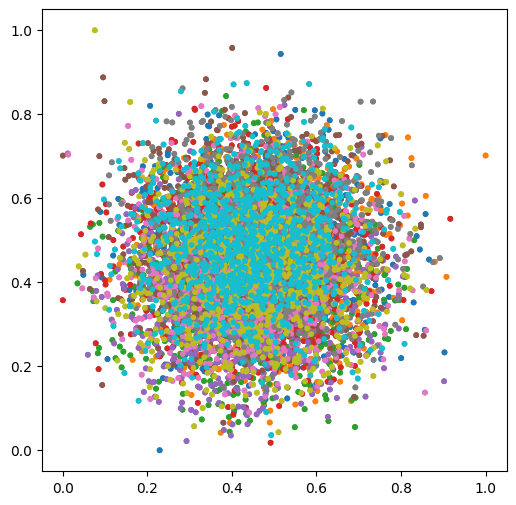

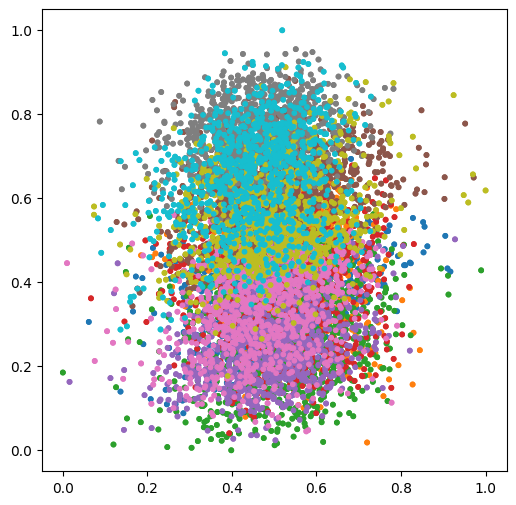

 67%|██████▋   | 4/6 [00:09<00:04,  2.25s/it]/var/folders/yh/rbd67mcj2zd4nychzgcydvt40000gn/T/ipykernel_96525/1944307494.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decoded_transformed = model2.decode(torch.tensor(transformed_latent_space, dtype=torch.float32).to(images.device)).detach().cpu().numpy()


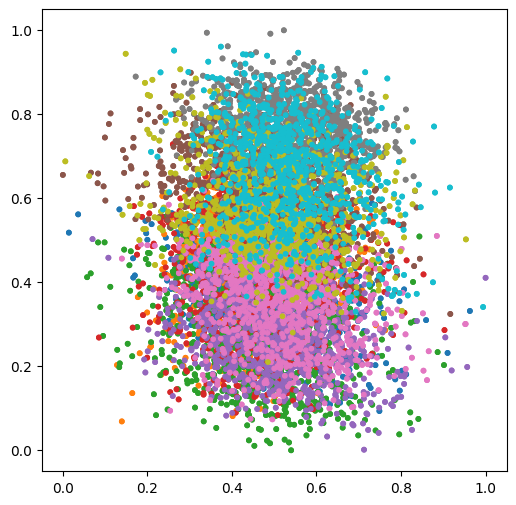

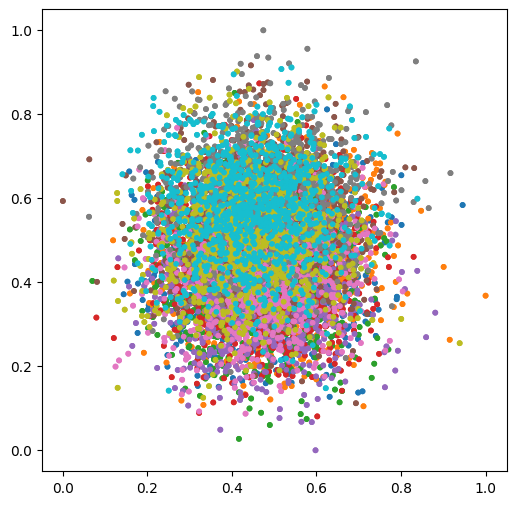

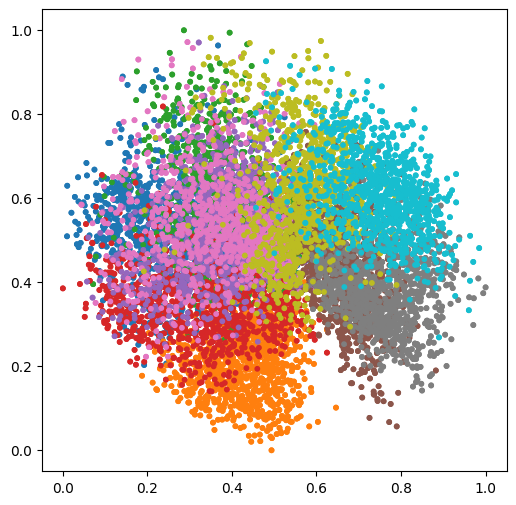

 83%|████████▎ | 5/6 [00:11<00:02,  2.23s/it]/var/folders/yh/rbd67mcj2zd4nychzgcydvt40000gn/T/ipykernel_96525/1944307494.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decoded_transformed = model2.decode(torch.tensor(transformed_latent_space, dtype=torch.float32).to(images.device)).detach().cpu().numpy()


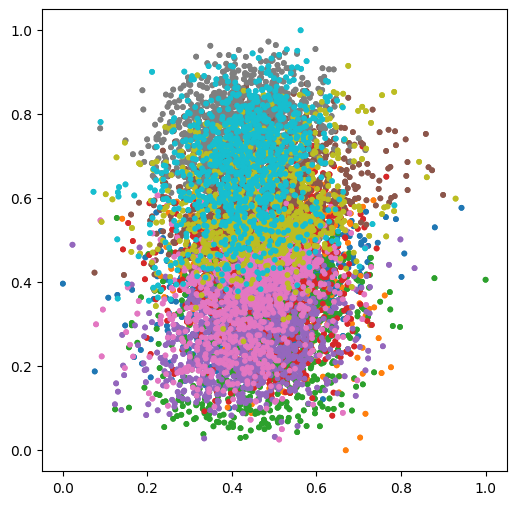

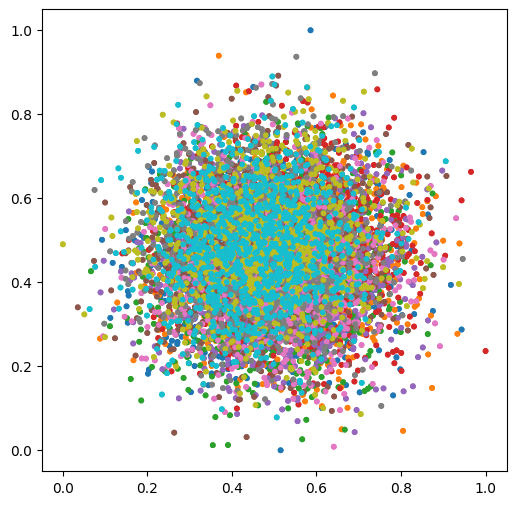

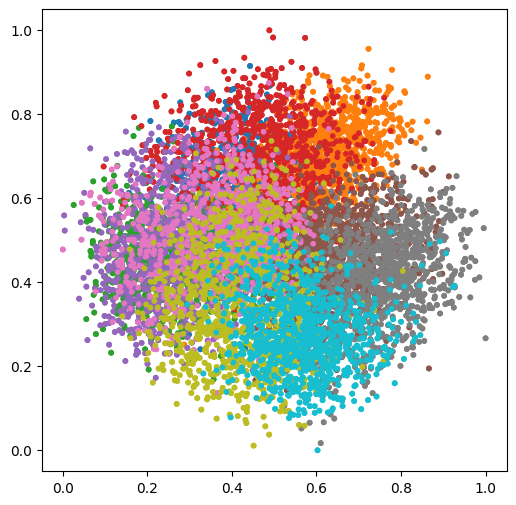

100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


In [9]:
##############################################
#Specify here which files you want to use



folder1 = "models/checkpoints/VAE/FMNIST"
folder2 = "models/checkpoints/VAE/FMNIST"
dataset="FMNIST"
number_samples = [50]
mapping_list = ["Affine"]
lamda_list = [0]
sampling_strategy = "equally"
filter = '_32_' #write here if you want that the processed files contain this string (example "_50_" to only process the files with latent size 50)
###############################################
## this autiomatically creates all the possible setups with the paramenters and the files you speicified, and sets up the correct dataset
files1 = [f for f in os.listdir(folder1) if f.endswith(".pth") and filter in f]
files2 = [f for f in os.listdir(folder2) if f.endswith(".pth") and filter in f]
list_of_files = [(f1, f2) for f1, f2 in itertools.product(files1, files2) if f1 != f2]
combinations_parameters = list(itertools.product(number_samples, mapping_list, lamda_list))
pbar = tqdm(list(itertools.product(list_of_files, combinations_parameters)))
images, labels, n_classes = define_dataloader(files1[0], files2[0], use_test_set=True)
images = images.type(torch.float32)
labels = labels.type(torch.float32)
criterion = nn.MSELoss()
# Result of all the combinations 
results_list = []
# Result for the classes 
results_list_classes = []
# Result for each sample 
results_top = []
# Get for each class the corresponding indices 
class_indices = {i: np.where(labels.numpy() == i)[0] for i in range(n_classes)}
# Get the corresponding class for each index
indices_class = {i: labels.numpy()[i] for i in range(len(labels))}



for (file1, file2), (num_samples, mapping_name, lamda) in pbar:
  name_dataset1, name_model1, size_of_the_latent1, seed1 = file1.strip(".pth").split("_")
  name_dataset2, name_model2, size_of_the_latent2, seed2 = file2.strip(".pth").split("_")
  #Load model
  model1 = load_model(model_name=name_model1, name_dataset=name_dataset1, latent_size=int(size_of_the_latent1), seed=int(seed1), model_path = folder1 +"/"+ file1)
  model2 = load_model(model_name=name_model2, name_dataset=name_dataset2, latent_size=int(size_of_the_latent2), seed=int(seed2), model_path = folder1 +"/"+ file2)
  #Load mapping
  mapping_path = f'results/transformations/mapping_files/{name_model2}/{file1.strip(".pth")}>{file2.strip(".pth")}>{mapping_name}_{num_samples}_{lamda}_{sampling_strategy}'
  mapping = load_mapping(mapping_path,mapping_name)
  #Calculate latent spaces
  latent_left = model1.get_latent_space(images).detach().cpu().numpy()
  latent_right = model2.get_latent_space(images).detach().cpu().numpy()
  transformed_latent_space = mapping.transform(latent_left)
  


  #Model1 output
  decoded_left = model1.decode(torch.tensor(latent_left, dtype=torch.float32).to(images.device)).detach().cpu().numpy()
  # Model2 output
  decoded_right = model2.decode(torch.tensor(latent_right, dtype=torch.float32).to(images.device)).detach().cpu().numpy()
  #Get stitched output
  decoded_transformed = model2.decode(torch.tensor(transformed_latent_space, dtype=torch.float32).to(images.device)).detach().cpu().numpy()

  # Vizualize the latent space via PCA
  # Plot the latent space
  visualize_latent_space(latent_left, labels)

  # Plot the transformed latent space
  visualize_latent_space(transformed_latent_space, labels)

  # Plot the latent space
  visualize_latent_space(latent_right, labels)
  


 
  
  


  


    

 


  
  
  

   